# Analysis of the distribution of interactions vs distance

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.signal import convolve2d
import math
import argparse
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import time
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

### Analyze distance vs dependency

In [4]:
seq_len = 1000

In [5]:
def create_rowise_dist_to_diag_matrix(N):
    # Create a range vector from 0 to N-1
    range_vector = np.arange(N)

    # subtract the transpose of the range_vector from itself and take the absolute value
    matrix = range_vector - range_vector[:, None]
    return matrix

In [6]:
dist_matrix = create_rowise_dist_to_diag_matrix(seq_len)
dist_matrix

array([[   0,    1,    2, ...,  997,  998,  999],
       [  -1,    0,    1, ...,  996,  997,  998],
       [  -2,   -1,    0, ...,  995,  996,  997],
       ...,
       [-997, -996, -995, ...,    0,    1,    2],
       [-998, -997, -996, ...,   -1,    0,    1],
       [-999, -998, -997, ...,   -2,   -1,    0]])

In [7]:
#create a matrix where every row contains the row index
row_matrix = np.repeat(np.arange(seq_len)[:, np.newaxis], seq_len, axis=1)
row_matrix

array([[  0,   0,   0, ...,   0,   0,   0],
       [  1,   1,   1, ...,   1,   1,   1],
       [  2,   2,   2, ...,   2,   2,   2],
       ...,
       [997, 997, 997, ..., 997, 997, 997],
       [998, 998, 998, ..., 998, 998, 998],
       [999, 999, 999, ..., 999, 999, 999]])

In [18]:
cowplot_theme = lambda figure_size : theme(
    # Set the background to white and remove panel border
    panel_background=element_blank(),
    panel_border=element_blank(),

    # Light grey grid lines
    panel_grid_major=element_line(color='lightgrey', size=0.5),
    panel_grid_minor=element_blank(),

    # Minimize axis ticks
    axis_ticks=element_blank(),
    #axis_text_x=element_text(rotation=45, hjust=1),

    # Simple font
    text=element_text(color='black', size=12),
    figure_size = figure_size
)

### Sample random interactions across all upstream regions in a species

In [177]:
dist_values_df = pd.read_csv(os.path.join(data_path, 'dist_values_scer_b1_1k_all_chrs_genome_wide.tsv'), sep='\t')
dist_values_df

,Chromosome,Start,End,dist,value
0,I,0,673,673.0,0.004013
1,I,2,127,125.0,0.089410
2,I,3,385,382.0,0.076783
3,I,5,361,356.0,0.041687
4,I,6,27,21.0,4.939713
...,...,...,...,...,...
20123995,XVI,947998,947053,-945.0,0.028049
20123996,XVI,947998,947227,-771.0,0.019207
20123997,XVI,947998,947876,-122.0,0.172913
20123998,XVI,947999,947475,-524.0,0.033294


In [178]:
dist_values_df['Chromosome'].unique()

array(['I', 'IV', 'IX', 'Mito', 'V', 'VI', 'VII', 'VIII', 'X', 'XI',
       'XII', 'XIII', 'XIV', 'XV', 'XVI'], dtype=object)

In [179]:
dist_values_df = dist_values_df[(dist_values_df.dist!=0)&(dist_values_df.value>1e-3)].copy() #pick values above (>1e-3) for numerical precision reasons
dist_values_df

,Chromosome,Start,End,dist,value
0,I,0,673,673.0,0.004013
1,I,2,127,125.0,0.089410
2,I,3,385,382.0,0.076783
3,I,5,361,356.0,0.041687
4,I,6,27,21.0,4.939713
...,...,...,...,...,...
20123995,XVI,947998,947053,-945.0,0.028049
20123996,XVI,947998,947227,-771.0,0.019207
20123997,XVI,947998,947876,-122.0,0.172913
20123998,XVI,947999,947475,-524.0,0.033294


In [180]:
dist_values_df['dist'] = np.abs(dist_values_df['dist'])

In [181]:
from sklearn.linear_model import LinearRegression

def fit_power_law(df):
   
    df['log_value'] = np.log(df['value'])
    df['log_dist'] = np.log(df['dist'])

    X = df[['log_dist']].values 
    y = df['log_value'].values

    model = LinearRegression()
    model.fit(X, y)

    A = np.exp(model.intercept_)
    k = model.coef_[0]

    df['fitted_log'] = model.predict(X)
    df['fitted'] = np.exp(model.predict(X))


    return df, A, k

In [182]:
df = dist_values_df.copy()
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df = df[df['value']>1e-3].copy()
df = df[df['dist']<=500].copy()
df

,Chromosome,Start,End,dist,value
1,I,2,127,125.0,0.089410
2,I,3,385,382.0,0.076783
3,I,5,361,356.0,0.041687
4,I,6,27,21.0,4.939713
7,I,9,346,337.0,0.026340
...,...,...,...,...,...
20123987,XVI,947985,947912,73.0,0.051359
20123989,XVI,947986,947932,54.0,0.978697
20123994,XVI,947995,947788,207.0,0.026604
20123997,XVI,947998,947876,122.0,0.172913


In [183]:
fitted_df, A, k = fit_power_law(df)

In [184]:
A,k

(1.041756177706993, -0.6537990987679203)

In [57]:
1-(10**-0.6537990987679203)

0.7780777222503286

In [185]:
fitted_df['residuals'] = fitted_df['value'] - fitted_df['fitted']
fitted_df['residuals_log'] = fitted_df['log_value'] - fitted_df['fitted_log']

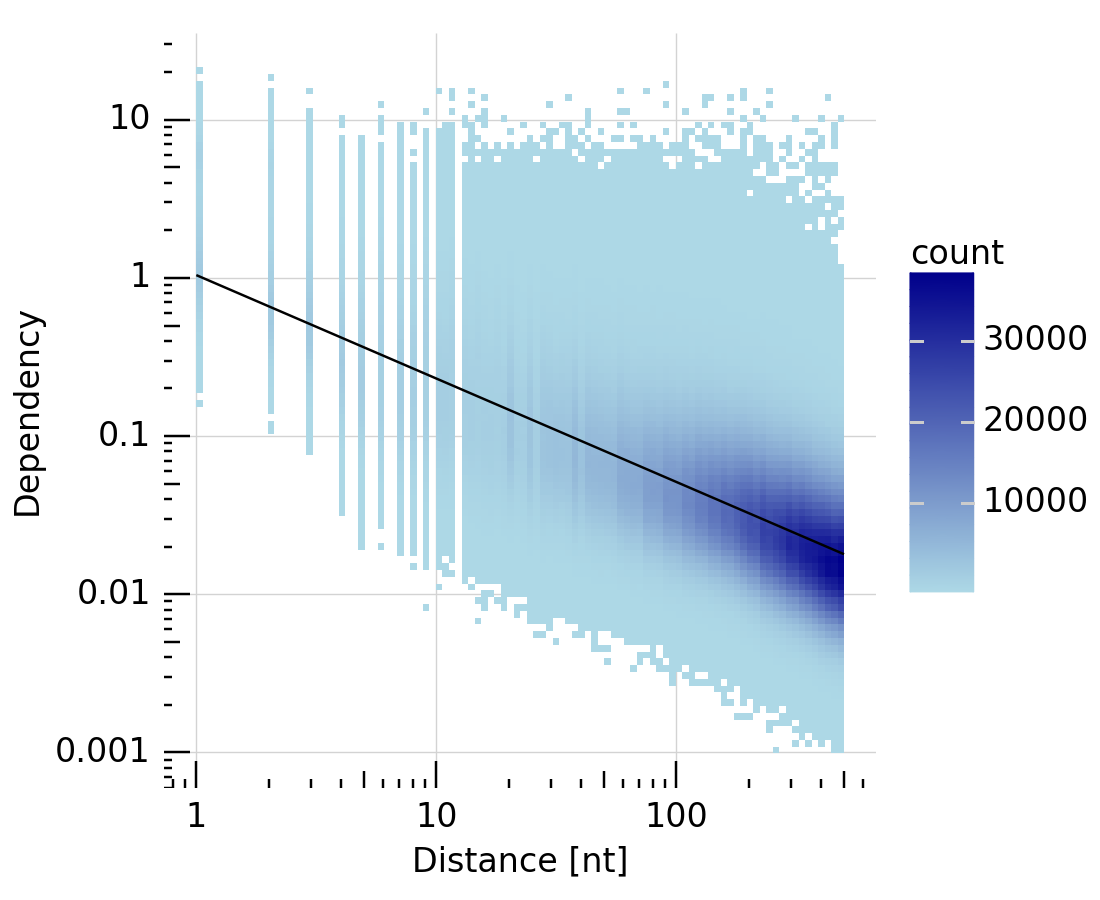

<Figure Size: (550 x 450)>

In [186]:
# Create the plot
p = (
    ggplot(fitted_df)
    + geom_bin2d(aes(x='dist', y='value'), bins=100)
    + geom_line(aes(x='dist', y='fitted'), color='black')
    + scale_fill_gradient(low="lightblue", high="darkblue", name="count")
    + cowplot_theme(figure_size=(5.5, 4.5))
    + scale_x_log10()
    + scale_y_log10()
    + annotation_logticks(sides='lb')
    + labs(x='Distance [nt]', y='Dependency')
)
p

In [18]:
median_fit_df = fitted_df.drop(['Chromosome', 'Start','End'],axis=1).groupby('dist').median().reset_index().sort_values('dist')
median_fit_df

,dist,value,log_value,log_dist,fitted_log,fitted,residuals,residuals_log
0,1.0,1.440658,0.365100,0.000000,0.145025,1.156068,0.284590,0.220075
1,2.0,0.775864,-0.253778,0.693147,-0.320320,0.725917,0.049947,0.066542
2,3.0,0.560678,-0.578609,1.098612,-0.592529,0.552927,0.007751,0.013920
3,4.0,0.354724,-1.036416,1.386294,-0.785665,0.455817,-0.101093,-0.250751
4,5.0,0.294157,-1.223641,1.609438,-0.935472,0.392401,-0.098243,-0.288169
...,...,...,...,...,...,...,...,...
495,496.0,0.016047,-4.132229,6.206576,-4.021763,0.017921,-0.001874,-0.110465
496,497.0,0.016010,-4.134552,6.208590,-4.023115,0.017897,-0.001887,-0.111437
497,498.0,0.016951,-4.077422,6.210600,-4.024465,0.017873,-0.000922,-0.052957
498,499.0,0.016088,-4.129707,6.212606,-4.025812,0.017849,-0.001761,-0.103895


In [19]:
median_fit_df['is_dist_multiple_3'] = median_fit_df['dist']%3==0

In [141]:
median_fit_df.to_csv(os.path.join(data_path, 'median_fit_s_cer.tsv'),sep='\t', index=False)

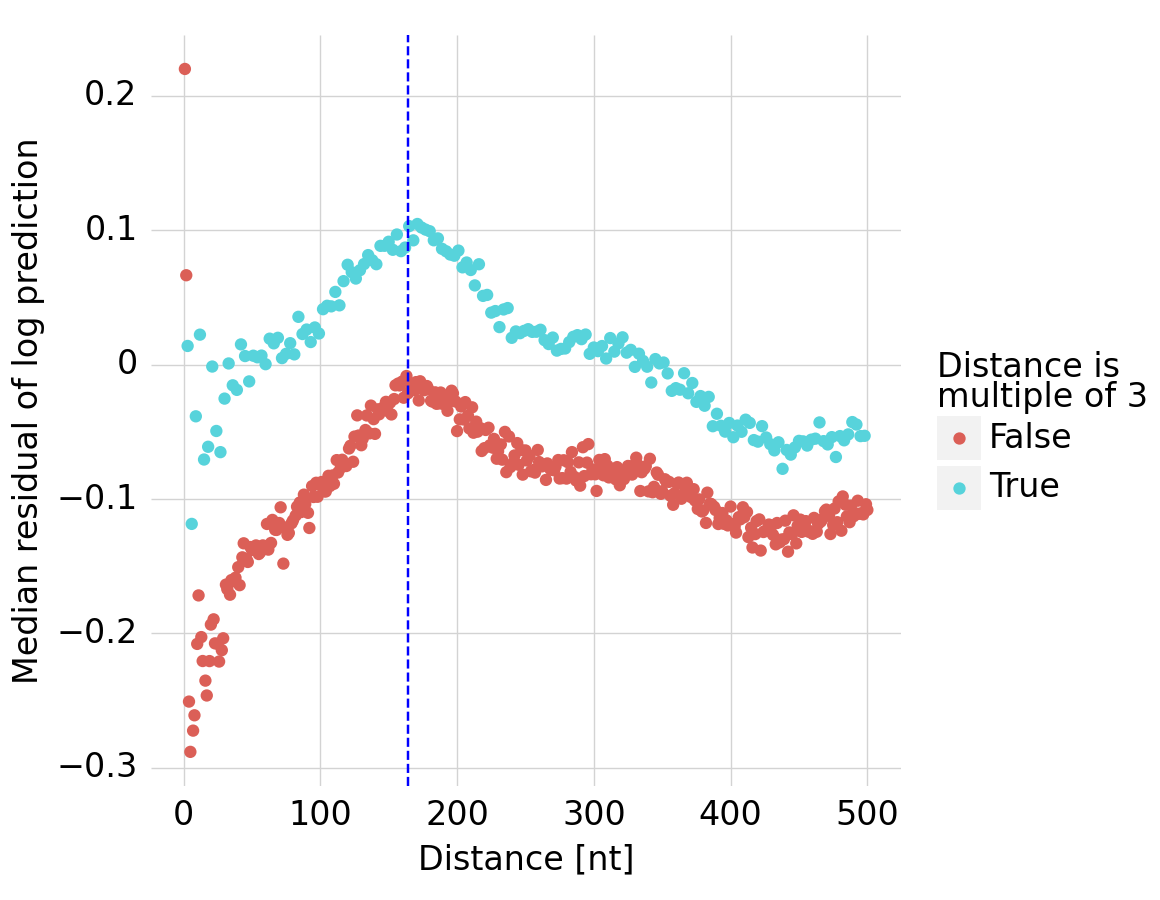

<Figure Size: (580 x 450)>

In [139]:
nucleosome_periodicity_cerevisiae = 164
p = (ggplot(median_fit_df, aes(x='dist', y='residuals_log', color='is_dist_multiple_3'))  
        + geom_point(alpha=1) 
        + geom_vline(xintercept=nucleosome_periodicity_cerevisiae, linetype='dashed', color='blue')
        + cowplot_theme(figure_size=(5.8,4.5)) 
        + labs(x='Distance [nt]', y='Median residual of log prediction', color='Distance is\nmultiple of 3\n'))
p

In [173]:
median_fit_scer = pd.read_csv(os.path.join(data_path, 'median_fit_s_cer.tsv'),sep='\t')
median_fit_scer['species'] = 'S. cerevisiae'

median_fit_pombe = pd.read_csv(os.path.join(data_path, 'median_fit_s_pombe.tsv'),sep='\t')
median_fit_pombe['species'] = 'S. pombe'

median_fit_all_species = pd.concat([median_fit_scer, median_fit_pombe])
median_fit_all_species

,dist,value,log_value,log_dist,fitted_log,fitted,residuals,residuals_log,is_dist_multiple_3,species,Unnamed: 0
0,1.0,1.440658,0.365100,0.000000,0.145025,1.156068,0.284590,0.220075,False,S. cerevisiae,NaN
1,2.0,0.775864,-0.253778,0.693147,-0.320320,0.725917,0.049947,0.066542,False,S. cerevisiae,NaN
2,3.0,0.560678,-0.578609,1.098612,-0.592529,0.552927,0.007751,0.013920,True,S. cerevisiae,NaN
3,4.0,0.354724,-1.036416,1.386294,-0.785665,0.455817,-0.101093,-0.250751,False,S. cerevisiae,NaN
4,5.0,0.294157,-1.223641,1.609438,-0.935472,0.392401,-0.098243,-0.288169,False,S. cerevisiae,NaN
...,...,...,...,...,...,...,...,...,...,...,...
495,496.0,0.013047,-4.339183,6.206576,-4.231822,0.014526,-0.001479,-0.107361,False,S. pombe,495.0
496,497.0,0.013188,-4.328423,6.208590,-4.233183,0.014506,-0.001318,-0.095240,False,S. pombe,496.0
497,498.0,0.013916,-4.274732,6.210600,-4.234540,0.014486,-0.000571,-0.040192,True,S. pombe,497.0
498,499.0,0.013104,-4.334859,6.212606,-4.235895,0.014467,-0.001363,-0.098964,False,S. pombe,498.0


In [174]:
median_fit_all_species['is_dist_multiple_3'] = median_fit_all_species['is_dist_multiple_3'].map({True:'Yes',False:'No'})
#reorder species factor levels
median_fit_all_species['species'] = pd.Categorical(median_fit_all_species['species'], 
                                                   categories=['S. pombe', 'S. cerevisiae'], 
                                                   ordered=True)


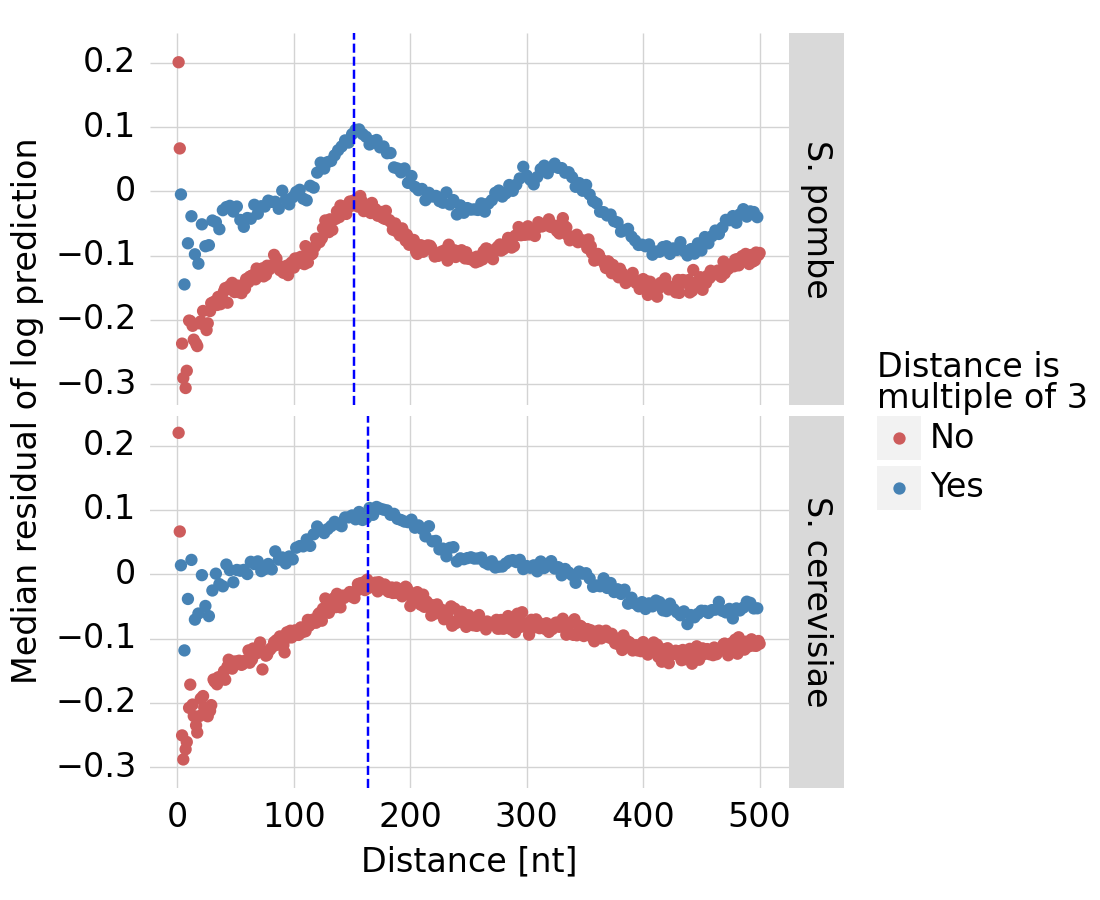

In [175]:
nucleosome_periodicity_cerevisiae = 164
nucleosome_periodicity_pombe = 152

p = (ggplot(median_fit_all_species, aes(x='dist', y='residuals_log', color='is_dist_multiple_3')) +
     geom_point(alpha=1) +
     geom_vline(median_fit_all_species[median_fit_all_species['species'] == 'S. cerevisiae'], 
                aes(xintercept=nucleosome_periodicity_cerevisiae), linetype='dashed', color='blue') +
     geom_vline(median_fit_all_species[median_fit_all_species['species'] == 'S. pombe'], 
                aes(xintercept=nucleosome_periodicity_pombe), linetype='dashed', color='blue') +
     cowplot_theme(figure_size=(5.5,4.5)) +
     labs(x='Distance [nt]', y='Median residual of log prediction', color='Distance is\nmultiple of 3\n') +
     facet_grid('species ~ .') +
     scale_color_manual(values=['indianred', 'steelblue']))

# Display the plot
print(p)

In [176]:
ggsave(p, "fig5_res_distance_periodicity.png",  dpi=500)

/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 5.5 x 4.5 in image.
/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /s/project/multispecies/fungi_code/ci_matrices/dna-lm-interactions-paper/figures/fig5_res_distance_periodicity.png


### Fourier analysis

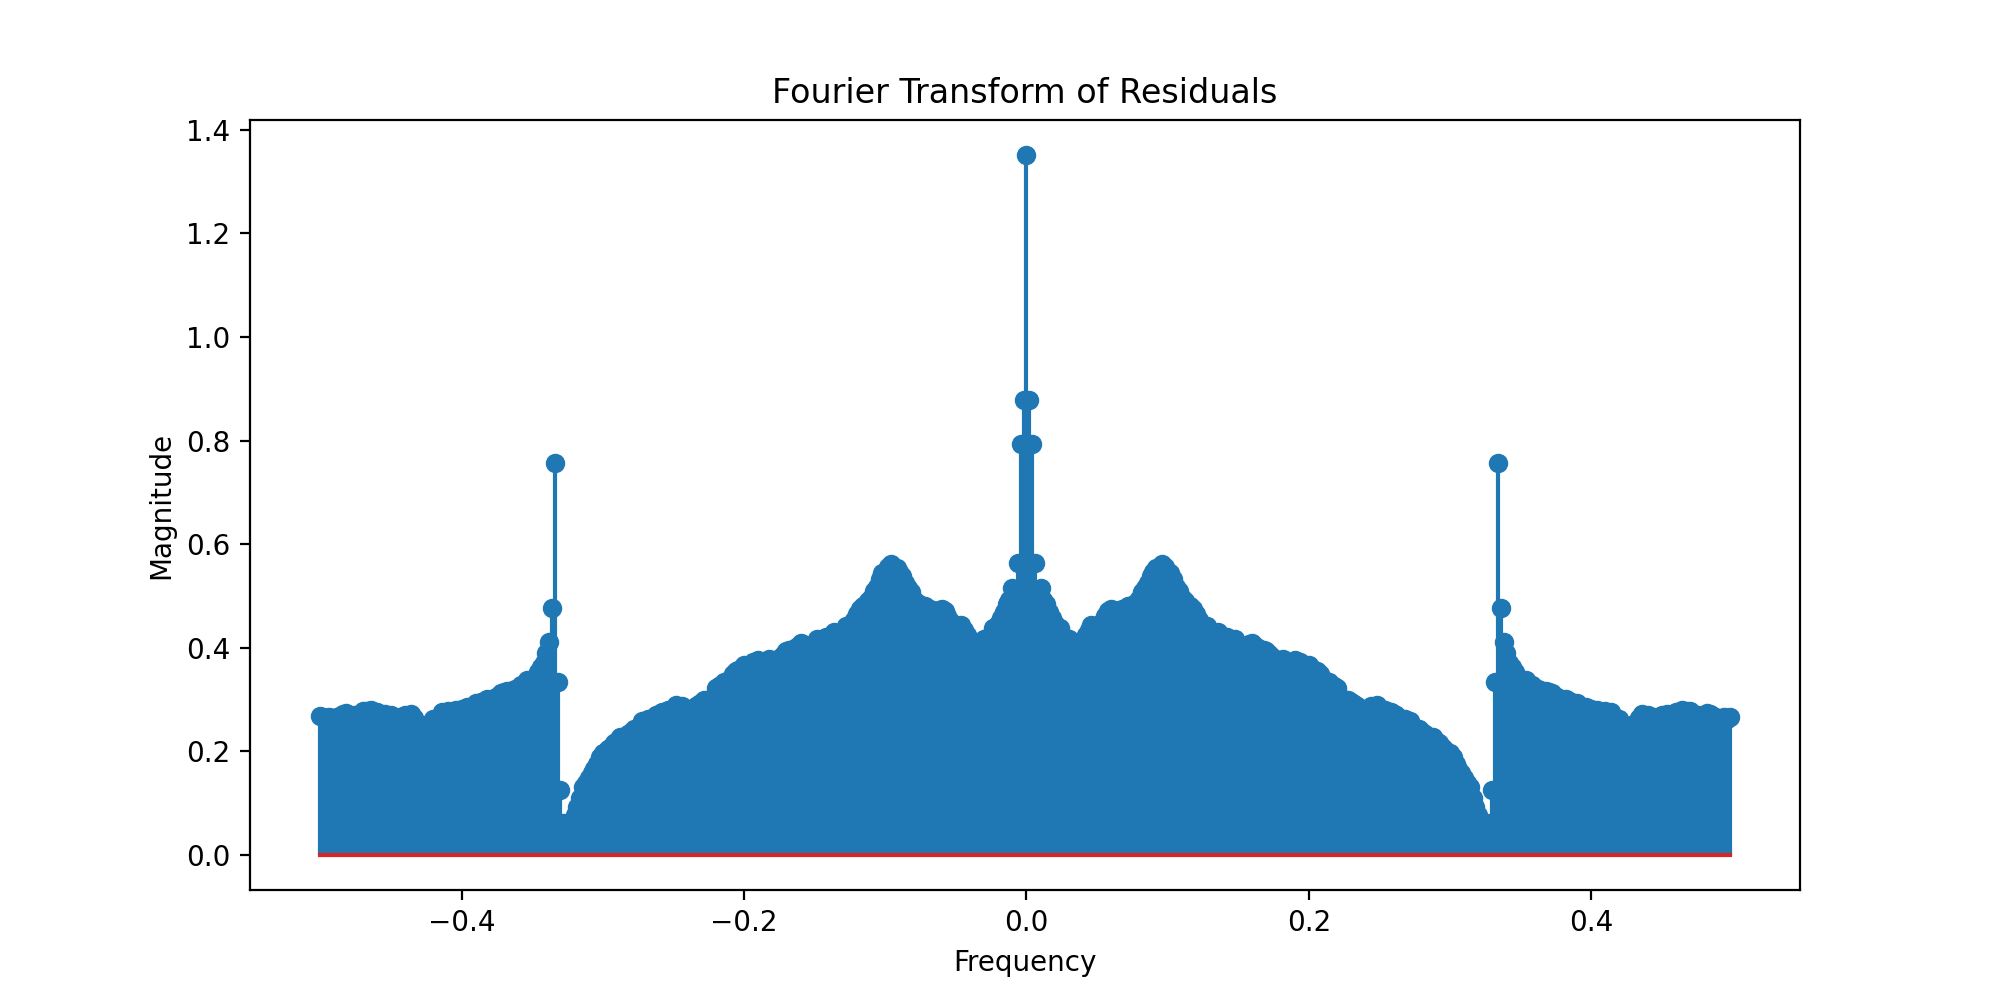

In [23]:
residuals = median_fit_df['residuals'].values

fft_values = np.fft.fft(residuals)
frequencies = np.fft.fftfreq(len(residuals), d=1)  # d is the sampling distance, adjust as necessary

# Magnitude of the FFT
magnitude = np.abs(fft_values)

plt.figure(figsize=(10, 5))
plt.stem(frequencies, magnitude)
plt.title('Fourier Transform of Residuals')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()


In [24]:
fft_df = pd.DataFrame({'frequency': frequencies, 'magnitude': magnitude})
fft_df['period'] = 1/fft_df['frequency']
fft_df

,frequency,magnitude,period
0,0.000,1.351427,inf
1,0.002,0.878665,500.000000
2,0.004,0.794370,250.000000
3,0.006,0.564113,166.666667
4,0.008,0.509686,125.000000
...,...,...,...
495,-0.010,0.515439,-100.000000
496,-0.008,0.509686,-125.000000
497,-0.006,0.564113,-166.666667
498,-0.004,0.794370,-250.000000


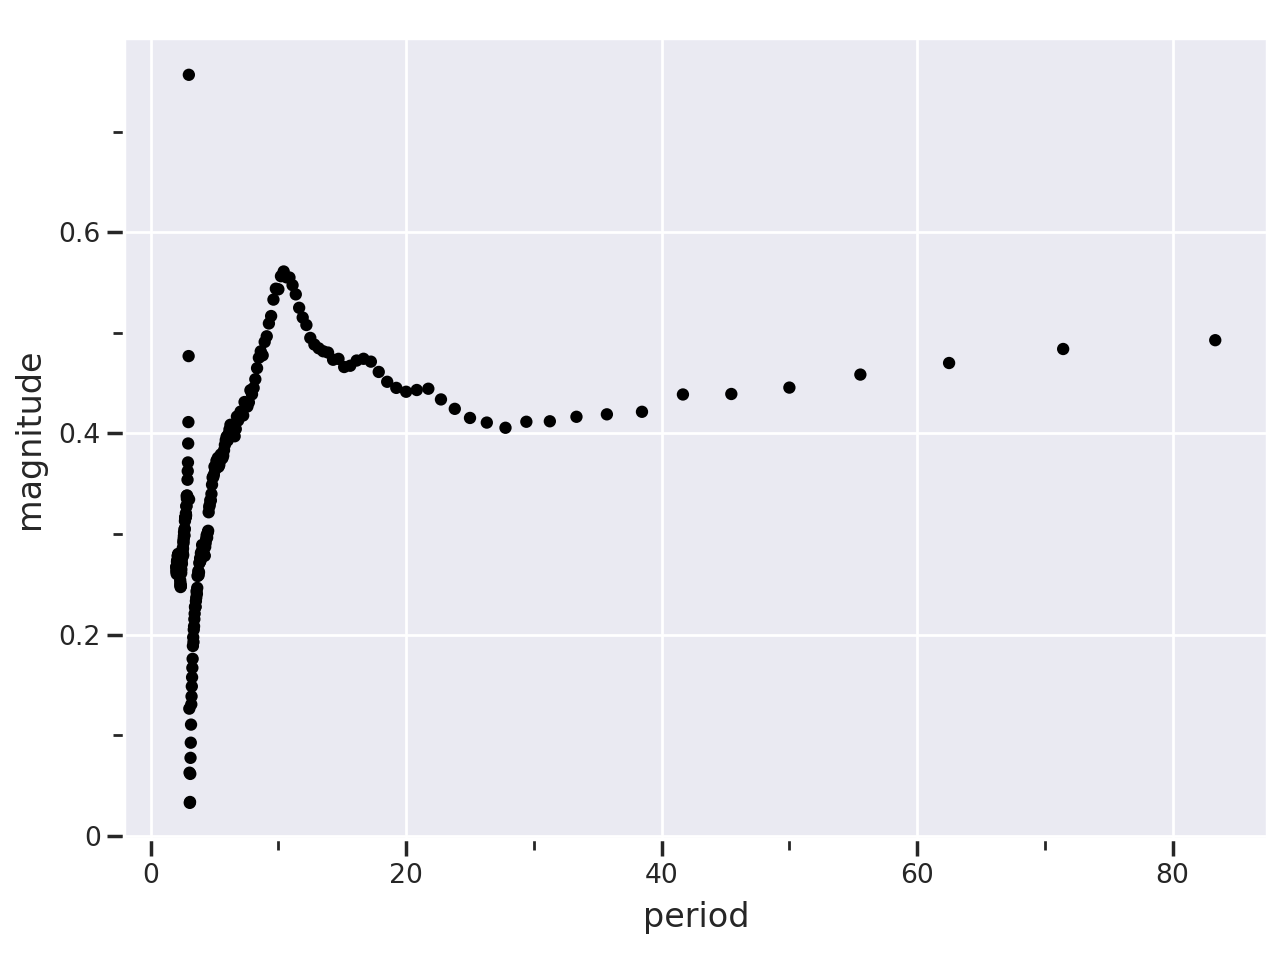

<Figure Size: (640 x 480)>

In [25]:
(ggplot(fft_df[(fft_df['period']<100)&(fft_df['period']>0)], aes(x='period', y='magnitude')) + geom_point() + theme_seaborn())

In [26]:
fft_df[(fft_df['period']<4)&(fft_df['period']>2)].sort_values('magnitude')

,frequency,magnitude,period
163,0.326,0.032693,3.067485
162,0.324,0.033567,3.086420
161,0.322,0.061486,3.105590
164,0.328,0.062687,3.048780
160,0.320,0.077435,3.125000
...,...,...,...
171,0.342,0.371061,2.923977
170,0.340,0.389901,2.941176
169,0.338,0.411166,2.958580
168,0.336,0.476769,2.976190


In [27]:
fft_df[(fft_df['period']<100)&(fft_df['period']>4)].sort_values('magnitude')

,frequency,magnitude,period
118,0.236,0.278303,4.237288
119,0.238,0.278506,4.201681
120,0.240,0.278806,4.166667
123,0.246,0.280479,4.065041
121,0.242,0.282365,4.132231
...,...,...,...
45,0.090,0.547265,11.111111
46,0.092,0.554873,10.869565
47,0.094,0.555027,10.638298
49,0.098,0.556173,10.204082


In [28]:
fft_df[(fft_df['period']<80)&(fft_df['period']>4)].loc[fft_df[(fft_df['period']<80)&(fft_df['period']>4)]['magnitude'].idxmax()]

frequency     0.096000
magnitude     0.560872
period       10.416667
Name: 48, dtype: float64

We get the 10.4 periodicity of DNA xD!

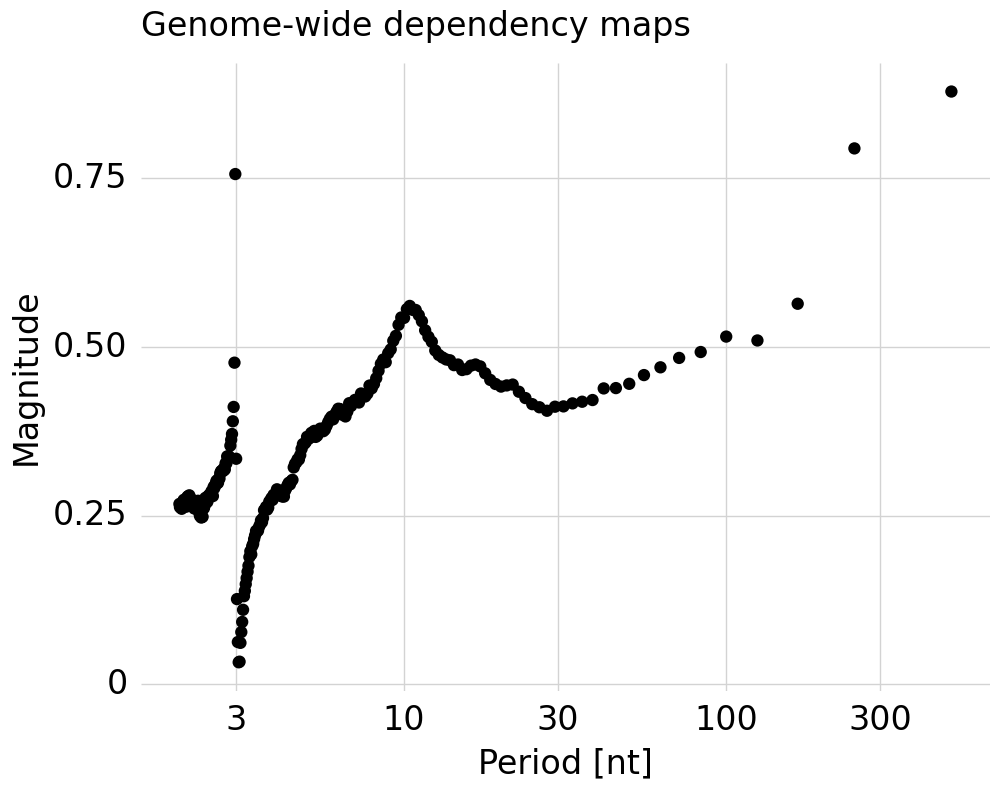

<Figure Size: (500 x 400)>

In [29]:
(ggplot(fft_df[(fft_df['period']>0)&(fft_df['period']!=np.inf)], aes(x='period', y='magnitude')) + geom_point() + cowplot_theme(figure_size=(5,4)) + scale_x_log10() + 
    labs(title='Genome-wide dependency maps', x='Period [nt]', y='Magnitude'))

## Region-specific relationships

In [ ]:
print('Selected GTF and fasta files:')
species_of_interest = 'saccharomyces_cerevisiae'
fasta_path = 'data/Saccharomyces_cerevisiae.R64-1-1.dna.toplevel.fa.gz'
gtf_path = 'data/Saccharomyces_cerevisiae.R64-1-1.53.gtf.gz'

In [35]:
import pyranges as pr
gtf_pr = pr.read_gtf(gtf_path)

## Decay per region

In [36]:

# next we will extract the introns from the exon annotations
# get only the protein coding exons. The non coding ones will be treated differently later on
gtf_df = gtf_pr.df.copy()
gtf_exons_df = gtf_df[(gtf_df.Feature == "exon") & (gtf_df.gene_biotype == "protein_coding")].copy() 

#For every gene we get the start and end coordinates and get the gaps between the exons as coordinates for introns
def get_introns(gene_df):
    
    gene_pr = pr.PyRanges(gene_df)
    gene = gene_pr.gene_id.unique()[0]
    print(gene)
    
    #Get boundaries of the whole gene defined by the exon
    #Pyranges boundaries returns them as float (very annoying bug) where they should be int. 
    #Converting them back to df and then to pyranges solves it ;)
    gene_boundaries_pr = pr.PyRanges(gene_pr.boundaries(group_by='Feature').df)

    introns_df = gene_boundaries_pr.subtract(gene_pr).df #get introns
    introns_df['Feature'] = 'intron'
    
    return introns_df

print('Getting introns...')
gtf_introns_df = gtf_exons_df.groupby('gene_id').apply(get_introns)
gtf_introns_df = gtf_introns_df.droplevel(1).reset_index()

gtf_w_introns_df = pd.concat([gtf_df, gtf_introns_df], axis=0)
gtf_w_introns_df

Getting introns...
Q0010
Q0017
Q0032
Q0045
Q0050
Q0055
Q0060
Q0065
Q0070
Q0075
Q0080
Q0085
Q0092
Q0105
Q0110
Q0115
Q0120
Q0130
Q0140
Q0142
Q0143
Q0144
Q0160
Q0182
Q0250
Q0255
Q0275
Q0297
YAL001C
YAL002W
YAL003W
YAL004W
YAL005C
YAL007C
YAL008W
YAL009W
YAL010C
YAL011W
YAL012W
YAL013W
YAL014C
YAL015C
YAL016C-A
YAL016C-B
YAL016W
YAL017W
YAL018C
YAL019W
YAL019W-A
YAL020C
YAL021C
YAL022C
YAL023C
YAL024C
YAL025C
YAL026C
YAL026C-A
YAL027W
YAL028W
YAL029C
YAL030W
YAL031C
YAL031W-A
YAL032C
YAL033W
YAL034C
YAL034C-B
YAL034W-A
YAL035W
YAL036C
YAL037C-A
YAL037C-B
YAL037W
YAL038W
YAL039C
YAL040C
YAL041W
YAL042C-A
YAL042W
YAL043C
YAL044C
YAL044W-A
YAL045C
YAL046C
YAL047C
YAL047W-A
YAL048C
YAL049C
YAL051W
YAL053W
YAL054C
YAL055W
YAL056C-A
YAL056W
YAL058W
YAL059C-A
YAL059W
YAL060W
YAL061W
YAL062W
YAL063C
YAL063C-A
YAL064C-A
YAL064W
YAL064W-B
YAL065C
YAL066W
YAL067C
YAL067W-A
YAL068C
YAL068W-A
YAL069W
YAR002C-A
YAR002W
YAR003W
YAR007C
YAR008W
YAR014C
YAR015W
YAR018C
YAR019C
YAR019W-A
YAR020C
YAR023C
YAR

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_name,gene_source,gene_biotype,transcript_id,transcript_name,transcript_source,transcript_biotype,exon_number,exon_id,protein_id
0,I,sgd,gene,74019.0,74823.0,.,+,.,YAL037W,NaN,sgd,protein_coding,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,I,sgd,transcript,74019.0,74823.0,.,+,.,YAL037W,NaN,sgd,protein_coding,YAL037W_mRNA,NaN,sgd,protein_coding,NaN,NaN,NaN
2,I,sgd,exon,74019.0,74823.0,.,+,.,YAL037W,NaN,sgd,protein_coding,YAL037W_mRNA,NaN,sgd,protein_coding,1,YAL037W_mRNA-E1,NaN
3,I,sgd,CDS,74019.0,74820.0,.,+,0,YAL037W,NaN,sgd,protein_coding,YAL037W_mRNA,NaN,sgd,protein_coding,1,NaN,YAL037W
4,I,sgd,start_codon,74019.0,74022.0,.,+,0,YAL037W,NaN,sgd,protein_coding,YAL037W_mRNA,NaN,sgd,protein_coding,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,XVI,NaN,intron,795029.0,795394.0,NaN,+,NaN,YPR132W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309,XVI,NaN,intron,833693.0,833827.0,NaN,+,NaN,YPR153W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310,XVI,NaN,intron,883387.0,883486.0,NaN,+,NaN,YPR170W-B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
311,XVI,NaN,intron,911276.0,911352.0,NaN,+,NaN,YPR187W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
label_dict = {'five_prime_utr': 'Protein-coding\ngene', 
              'three_prime_utr': 'Protein-coding\ngene', 
              'tRNA_pseudogene': 'Structured RNA', 
              'tRNA': 'Structured RNA', 
              'intron': 'Intron',
              'rRNA': 'Structured RNA', 
              'snRNA': 'Structured RNA',  
              'ribozyme': 'Structured RNA', 
              'pseudogene': 'Protein-coding\ngene',
               #'ncRNA': 'Intergenic &\n non-coding RNA',
              'pseudogene_with_CDS': 'Protein-coding\ngene', 
              'CDS':'Protein-coding\ngene', 
              'SRP_RNA': 'Structured RNA',  
              'snoRNA': 'Structured RNA', 
              'transposable_element': 'Intergenic', 
              'RNase_P_RNA': 'Structured RNA', 
              'RNase_MRP_RNA': 'Structured RNA', 
              'intergenic':'Intergenic'}

In [73]:
# now we get the CDS five_prime_utr and three_prime_utr of the coding genes plus the gene annoation of the non coding genes
gtf_processed_df = gtf_w_introns_df[(gtf_w_introns_df.Feature=='CDS') | (gtf_w_introns_df.Feature=='five_prime_utr') | (gtf_w_introns_df.Feature=='three_prime_utr') | 
                                    (gtf_w_introns_df.Feature=='intron') | ((gtf_w_introns_df.gene_biotype!='protein_coding') & (gtf_w_introns_df.Feature=='gene'))].copy()

gtf_processed_df['processed_feature'] = gtf_processed_df.apply(lambda row: row.Feature if 
                                                               (row.gene_biotype == 'protein_coding') or (row.Feature=='intron') else row.gene_biotype, axis=1)

gtf_processed_df['nuclear_or_mito'] = gtf_processed_df.apply(lambda row: 'Mitochondria' if row.Chromosome == 'Mito' else 'Nuclear', axis=1) #compute mito feature

gtf_processed_df = gtf_processed_df[gtf_processed_df.processed_feature!='ncRNA'].copy()
#some genomic intervals may belong to more than one gene id annotation. Check for example the intron in SPAC823.02 and SPAC823.17 in S Pombe. 
# we will keep one genomic interval + feature randomly if duplicates exist
gtf_processed_df.drop_duplicates(subset=['Chromosome', 'Start', 'End', 'Strand', 'processed_feature'], keep='first', inplace=True)
gtf_processed_df.replace(label_dict, inplace=True)
gtf_processed_pr = pr.PyRanges(gtf_processed_df)
gtf_processed_pr

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_name,...,gene_biotype,transcript_id,transcript_name,transcript_source,transcript_biotype,exon_number,exon_id,protein_id,processed_feature,nuclear_or_mito
0,I,sgd,Protein-coding\ngene,74019,74820,.,+,0,YAL037W,NaN,...,protein_coding,YAL037W_mRNA,NaN,sgd,protein_coding,1,NaN,YAL037W,Protein-coding\ngene,Nuclear
1,I,sgd,Protein-coding\ngene,124878,126783,.,+,0,YAL016W,TPD3,...,protein_coding,YAL016W_mRNA,TPD3,sgd,protein_coding,1,NaN,YAL016W,Protein-coding\ngene,Nuclear
2,I,sgd,Protein-coding\ngene,142173,142253,.,+,0,YAL003W,EFB1,...,protein_coding,YAL003W_mRNA,EFB1,sgd,protein_coding,1,NaN,YAL003W,Protein-coding\ngene,Nuclear
3,I,sgd,Protein-coding\ngene,142619,143157,.,+,1,YAL003W,EFB1,...,protein_coding,YAL003W_mRNA,EFB1,sgd,protein_coding,2,NaN,YAL003W,Protein-coding\ngene,Nuclear
4,I,sgd,Protein-coding\ngene,45898,48247,.,+,0,YAL053W,FLC2,...,protein_coding,YAL053W_mRNA,FLC2,sgd,protein_coding,1,NaN,YAL053W,Protein-coding\ngene,Nuclear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7702,XVI,NaN,Intron,75985,76223,NaN,-,NaN,YPL249C-A,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Intron,Nuclear
7703,XVI,NaN,Intron,5840,5988,NaN,-,NaN,YPL283C,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Intron,Nuclear
7704,XVI,NaN,Intron,582558,582701,NaN,-,NaN,YPR010C-A,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Intron,Nuclear
7705,XVI,NaN,Intron,678193,678279,NaN,-,NaN,YPR063C,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Intron,Nuclear


In [74]:
all_features = gtf_processed_df.processed_feature.unique()
all_features

array(['Protein-coding\ngene', 'Structured RNA', 'Intergenic', 'Intron'],
      dtype=object)

In [72]:
df

,Chromosome,Start,End,dist,value,log_value,log_dist,fitted_log,fitted,residuals,residuals_log
0,I,0,326,326.0,0.024927,-3.691797,5.786897,-3.740012,0.023754,0.001173,0.048215
1,I,1,130,129.0,0.073228,-2.614179,4.859812,-3.117613,0.044263,0.028965,0.503434
2,I,1,355,354.0,0.018196,-4.006536,5.869297,-3.795331,0.022475,-0.004279,-0.211205
3,I,2,315,313.0,0.013646,-4.294326,5.746203,-3.712692,0.024412,-0.010766,-0.581634
4,I,8,145,137.0,0.080318,-2.521758,4.919981,-3.158007,0.042510,0.037808,0.636249
...,...,...,...,...,...,...,...,...,...,...,...
11049994,XIII,435998,435821,177.0,0.036933,-3.298638,5.176150,-3.329986,0.035794,0.001140,0.031348
11049995,XIII,435998,435834,164.0,0.043610,-3.132463,5.099866,-3.278773,0.037674,0.005936,0.146311
11049996,XIII,435998,435975,23.0,0.130904,-2.033288,3.135494,-1.959991,0.140860,-0.009955,-0.073298
11049998,XIII,435999,435839,160.0,0.034611,-3.363571,5.075174,-3.262196,0.038304,-0.003693,-0.101375


In [77]:
A_vec_features = []
k_vec_features = []
deps_join_df_list = []

for feature in ['Protein-coding\ngene', 'Structured RNA', 'Intron']:
    gtf_feature_pr = gtf_processed_pr[gtf_processed_pr.processed_feature == feature]
    dist_dep_pr = pr.PyRanges(df)
    deps_join_df = dist_dep_pr.join(gtf_feature_pr, suffix='_feature', report_overlap=True).df


    deps_join_df = deps_join_df[deps_join_df['dist'] == deps_join_df['Overlap']].copy().reset_index(drop=True) #depednencies must fully overlap the region we are looking at
    deps_join_df = deps_join_df.loc[:, ['Chromosome', 'Start', 'End', 'dist', 'value']].drop_duplicates().copy()
    deps_join_df_list.append(deps_join_df)

    if len(deps_join_df) == 0:
        A_vec_features.append(np.nan)
        k_vec_features.append(np.nan)
        continue

    fitted_feature_df, A_feature, k_feature = fit_power_law(deps_join_df)
    A_vec_features.append(A_feature)
    k_vec_features.append(k_feature)


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


In [78]:
all_deps_join_df = pd.concat(deps_join_df_list, axis=0)
intergenic_idxs = df.set_index(['Chromosome','Start', 'End','dist']).index.difference(all_deps_join_df.set_index(['Chromosome','Start', 'End','dist']).index)
intergenic_df = df.set_index(['Chromosome',	'Start', 'End',	'dist']).loc[intergenic_idxs].reset_index().copy()
intergenic_df = intergenic_df.loc[:, ['Chromosome', 'Start', 'End', 'dist', 'value']].drop_duplicates().copy()
intergenic_df

,Chromosome,Start,End,dist,value
0,I,0,326,326.0,0.024927
1,I,1,130,129.0,0.073228
2,I,1,355,354.0,0.018196
3,I,2,315,313.0,0.013646
4,I,8,145,137.0,0.080318
...,...,...,...,...,...
5260511,XIII,435998,435821,177.0,0.036933
5260512,XIII,435998,435834,164.0,0.043610
5260513,XIII,435998,435975,23.0,0.130904
5260514,XIII,435999,435839,160.0,0.034611


In [79]:
fitted_feature_df, A_feature, k_feature = fit_power_law(intergenic_df)
A_vec_features.append(A_feature)
k_vec_features.append(k_feature)

In [85]:
gtf_processed_pr

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_name,...,gene_biotype,transcript_id,transcript_name,transcript_source,transcript_biotype,exon_number,exon_id,protein_id,processed_feature,nuclear_or_mito
0,I,sgd,Protein-coding\ngene,74019,74820,.,+,0,YAL037W,NaN,...,protein_coding,YAL037W_mRNA,NaN,sgd,protein_coding,1,NaN,YAL037W,Protein-coding\ngene,Nuclear
1,I,sgd,Protein-coding\ngene,124878,126783,.,+,0,YAL016W,TPD3,...,protein_coding,YAL016W_mRNA,TPD3,sgd,protein_coding,1,NaN,YAL016W,Protein-coding\ngene,Nuclear
2,I,sgd,Protein-coding\ngene,142173,142253,.,+,0,YAL003W,EFB1,...,protein_coding,YAL003W_mRNA,EFB1,sgd,protein_coding,1,NaN,YAL003W,Protein-coding\ngene,Nuclear
3,I,sgd,Protein-coding\ngene,142619,143157,.,+,1,YAL003W,EFB1,...,protein_coding,YAL003W_mRNA,EFB1,sgd,protein_coding,2,NaN,YAL003W,Protein-coding\ngene,Nuclear
4,I,sgd,Protein-coding\ngene,45898,48247,.,+,0,YAL053W,FLC2,...,protein_coding,YAL053W_mRNA,FLC2,sgd,protein_coding,1,NaN,YAL053W,Protein-coding\ngene,Nuclear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7702,XVI,NaN,Intron,75985,76223,NaN,-,NaN,YPL249C-A,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Intron,Nuclear
7703,XVI,NaN,Intron,5840,5988,NaN,-,NaN,YPL283C,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Intron,Nuclear
7704,XVI,NaN,Intron,582558,582701,NaN,-,NaN,YPR010C-A,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Intron,Nuclear
7705,XVI,NaN,Intron,678193,678279,NaN,-,NaN,YPR063C,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Intron,Nuclear


In [86]:
A_vec_region = []
k_vec_region = []
deps_join_df_list = []

for region in ['Mitochondria', 'Nuclear']:
    gtf_feature_pr = gtf_processed_pr[gtf_processed_pr.nuclear_or_mito == region]
    dist_dep_pr = pr.PyRanges(df)
    deps_join_df = dist_dep_pr.join(gtf_feature_pr, suffix='_feature', report_overlap=True).df


    deps_join_df = deps_join_df[deps_join_df['dist'] == deps_join_df['Overlap']].copy().reset_index(drop=True) #depednencies must fully overlap the region we are looking at
    deps_join_df = deps_join_df.loc[:, ['Chromosome', 'Start', 'End', 'dist', 'value']].drop_duplicates().copy()
    deps_join_df_list.append(deps_join_df)

    if len(deps_join_df) == 0:
        A_vec_region.append(np.nan)
        k_vec_region.append(np.nan)
        continue

    fitted_feature_df, A_region, k_region = fit_power_law(deps_join_df)
    A_vec_region.append(A_region)
    k_vec_region.append(k_region)


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


In [132]:
features = ['Protein-coding\ngene', 'Structured RNA', 'Intron', 'Intergenic']
regions = ['Mitochondria', 'Nuclear']
types_decay_df = pd.DataFrame({'feature':features + regions, 
                               'A':A_vec_features+A_vec_region, 'k':k_vec_features+k_vec_region,
                               'is_region':len(features)*[False] + len(regions) * [True]})
types_decay_df

,feature,A,k,is_region
0,Protein-coding\ngene,1.037676,-0.634598,False
1,Structured RNA,1.576307,-0.704650,False
2,Intron,0.759824,-0.529823,False
3,Intergenic,1.190954,-0.683315,False
4,Mitochondria,1.686166,-0.647778,True
5,Nuclear,1.030376,-0.634303,True


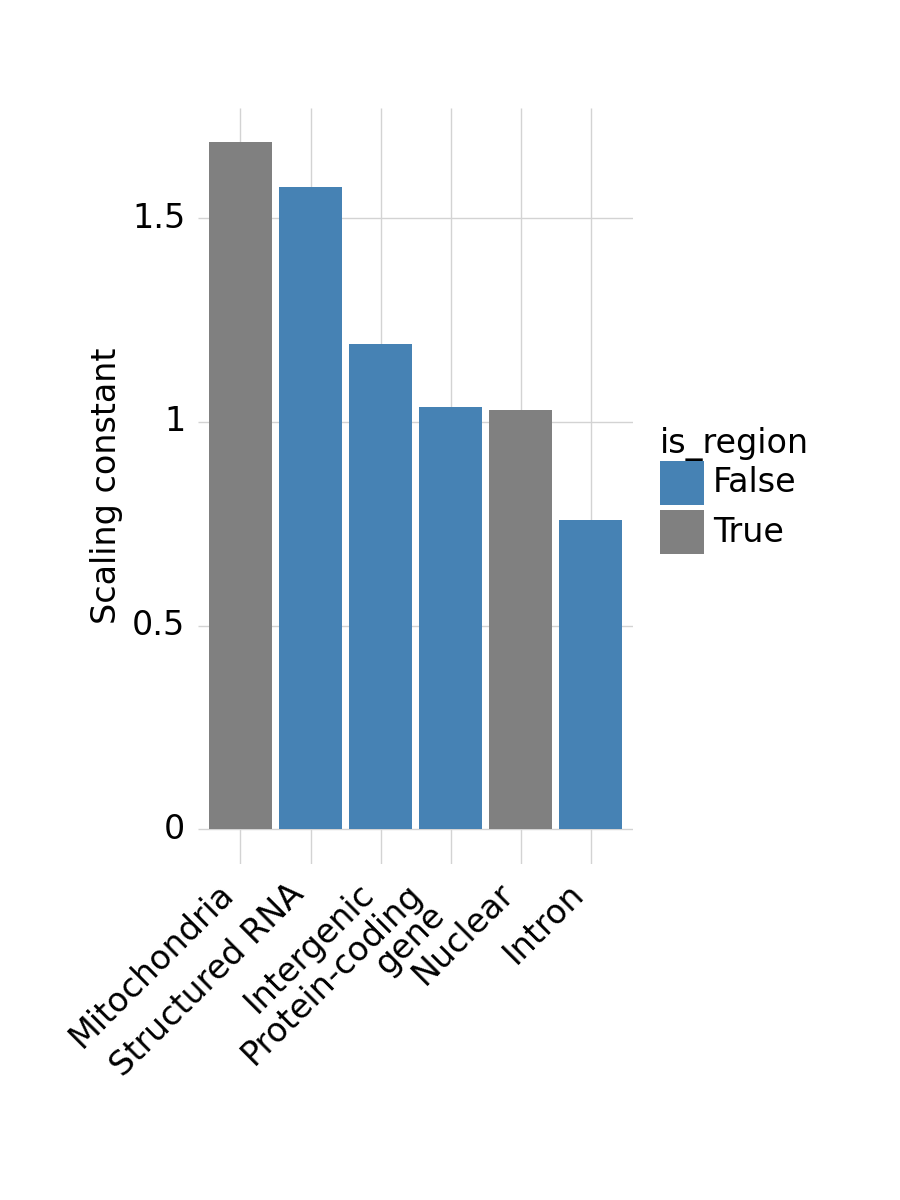

<Figure Size: (450 x 600)>

In [100]:
#make categoricval of feature oredered by decay
types_decay_df['feature'] = pd.Categorical(types_decay_df['feature'], categories=types_decay_df.sort_values('A', ascending=False)['feature'], ordered=True)

p =(ggplot(types_decay_df.dropna(), aes(x='feature', y='A', fill='is_region')) + 
     geom_col() + 
     cowplot_theme(figure_size=(4.5,6)) + 
     theme(axis_text_x=element_text(rotation=45, hjust=1), plot_margin=.1) + 
     scale_fill_manual(values=['steelblue', 'grey']) +
     labs(x='', y='Scaling constant'))
p

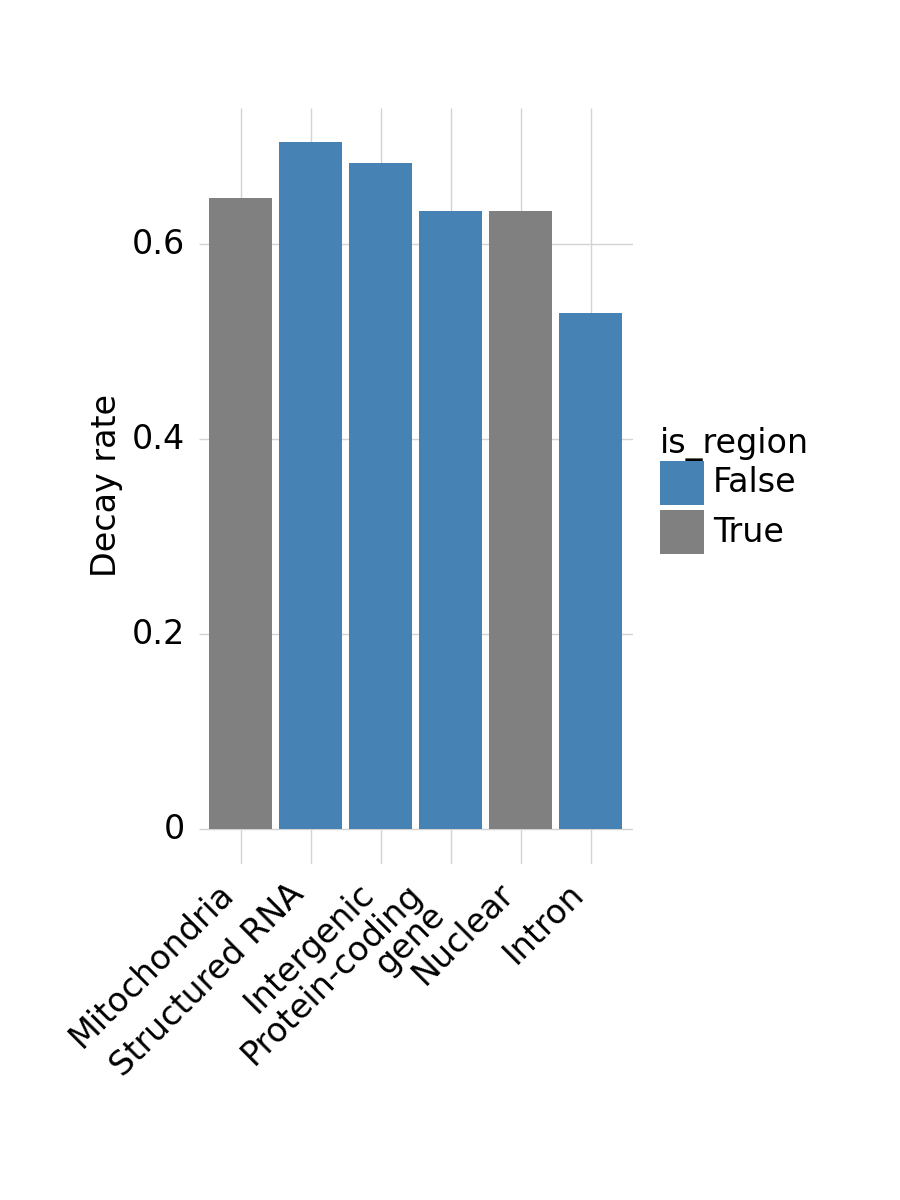

<Figure Size: (450 x 600)>

In [104]:
types_decay_df['feature'] = types_decay_df['feature'].replace(label_dict)
#make categoricval of feature oredered by decay
p =(ggplot(types_decay_df.dropna(), aes(x='feature', y='-k', fill='is_region')) + 
     geom_col() + 
     cowplot_theme(figure_size=(4.5,6)) + 
     theme(axis_text_x=element_text(rotation=45, hjust=1), plot_margin=.1) + 
     scale_fill_manual(values=['steelblue', 'grey']) +
     labs(x='', y='Decay rate'))
p

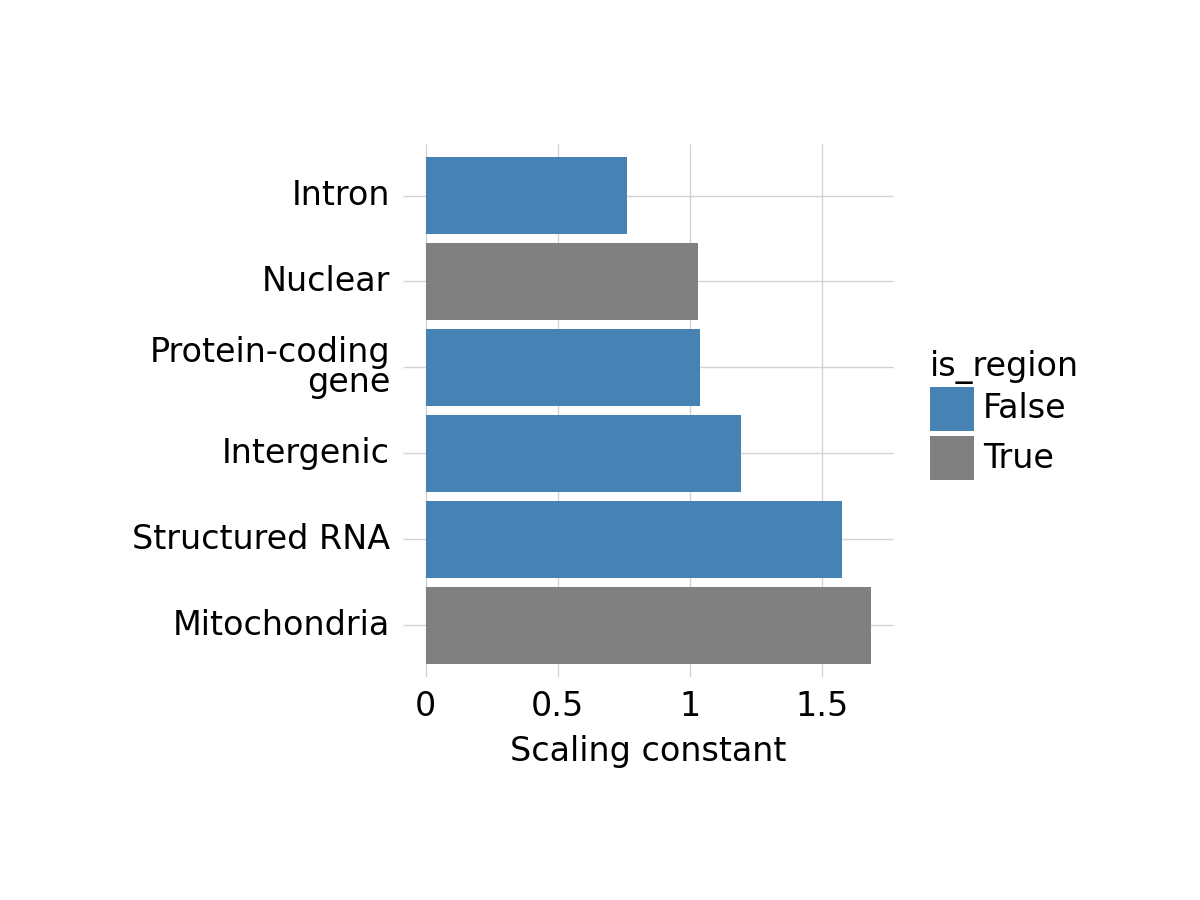

<Figure Size: (600 x 450)>

In [109]:
#make categoricval of feature oredered by decay
types_decay_df['feature'] = pd.Categorical(types_decay_df['feature'], categories=types_decay_df.sort_values('A', ascending=False)['feature'], ordered=True)

p =(ggplot(types_decay_df.dropna(), aes(x='feature', y='A', fill='is_region')) + 
     geom_col() + 
     cowplot_theme(figure_size=(6,4.5)) + 
     theme( plot_margin=.1) + 
     scale_fill_manual(values=['steelblue', 'grey']) +
     labs(x='', y='Scaling constant')+
     coord_flip())
p

In [ ]:
ggsave(p, "fig5_scaling_constant_w_mito_nuclear.png",  dpi=500)

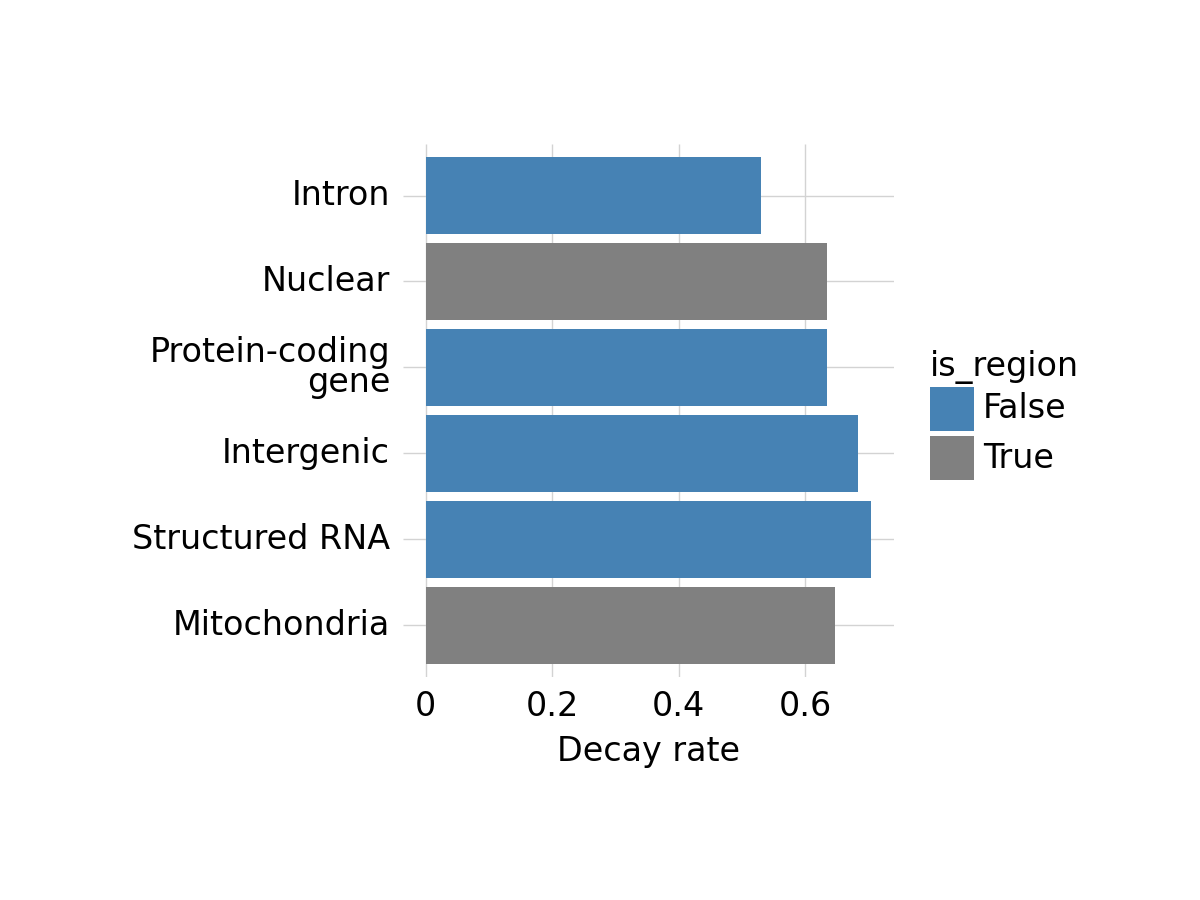

<Figure Size: (600 x 450)>

In [111]:
types_decay_df['feature'] = types_decay_df['feature'].replace(label_dict)
#make categoricval of feature oredered by decay
p =(ggplot(types_decay_df.dropna(), aes(x='feature', y='-k', fill='is_region')) + 
     geom_col() + 
     cowplot_theme(figure_size=(6,4.5)) + 
     theme(plot_margin=.1) + 
     scale_fill_manual(values=['steelblue', 'grey']) +
     labs(x='', y='Decay rate')+
    coord_flip())
p

In [ ]:
ggsave(p, "fig5_decay_rate_w_mito_nuclear.png",  dpi=500)

In [133]:
types_decay_df['feature'] = pd.Categorical(types_decay_df['feature'], categories=['Intron', 'Protein-coding\ngene', 'Intergenic', 'Structured RNA', 'Mitochondria','Nuclear'], ordered=True)

In [134]:
types_decay_melted_df = types_decay_df.melt(id_vars=['feature','is_region'], var_name='coef_type')
types_decay_melted_df['coef_type'] = types_decay_melted_df['coef_type'].map({'A':'Scaling constant', 'k':'Decay rate'}) 
types_decay_melted_df

,feature,is_region,coef_type,value
0,Protein-coding\ngene,False,Scaling constant,1.037676
1,Structured RNA,False,Scaling constant,1.576307
2,Intron,False,Scaling constant,0.759824
3,Intergenic,False,Scaling constant,1.190954
4,Mitochondria,True,Scaling constant,1.686166
5,Nuclear,True,Scaling constant,1.030376
6,Protein-coding\ngene,False,Decay rate,-0.634598
7,Structured RNA,False,Decay rate,-0.704650
8,Intron,False,Decay rate,-0.529823
9,Intergenic,False,Decay rate,-0.683315


In [138]:
types_decay_melted_df.to_csv(os.path.join(data_path, "decay_scaling_constant_scer.tsv"), sep='\t')

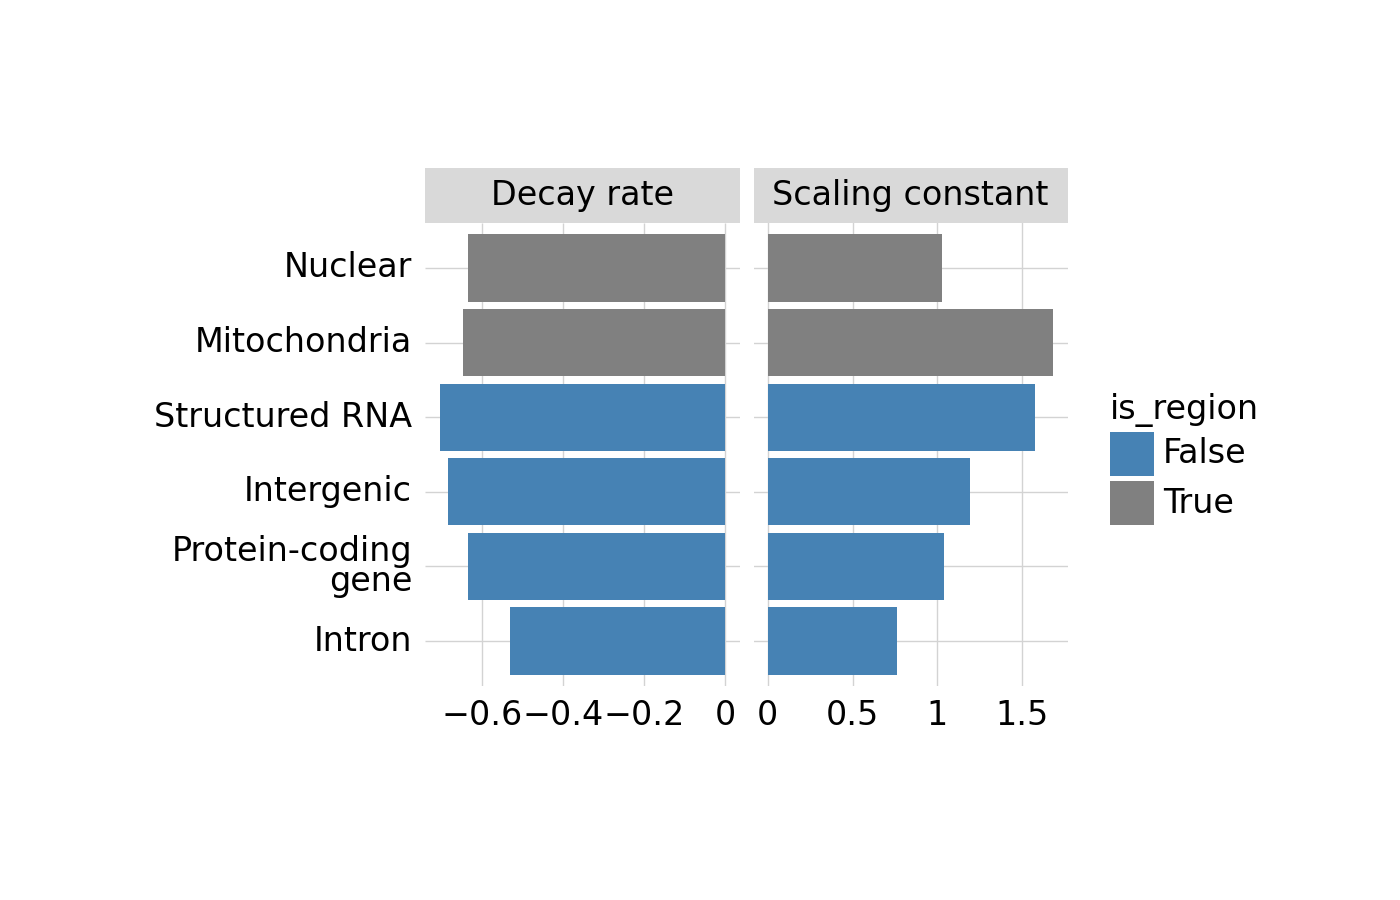

<Figure Size: (700 x 450)>

In [135]:
p_combined = (ggplot(types_decay_melted_df, aes(x='feature', y='value', fill='is_region')) + 
              geom_col() + 
              cowplot_theme(figure_size=(7,4.5)) + 
              theme(plot_margin=.1) + 
              scale_fill_manual(values=['steelblue', 'grey']) +
              labs(x='', y='') +
              coord_flip() +
              facet_grid(' ~ coef_type', scales='free_x', space='free_x') )
p_combined

In [51]:
types_decay_melted_df['coef_type'] = types_decay_melted_df['coef_type'].map({'Scaling constant':'Scaling constant', 'Decay rate':'Decay rate (%)' })

In [52]:
types_decay_melted_df['feature'] = pd.Categorical(types_decay_melted_df['feature'], categories=['Intron', 'Protein-coding\ngene', 'Intergenic', 'Structured RNA', 'Mitochondria','Nuclear'], ordered=True)

In [53]:
#transform decay rate to dependency decrease per 10fold increase in distance
types_decay_melted_df.loc[types_decay_melted_df['coef_type']=='Decay rate (%)', 'value'] = -100*(1-10**types_decay_melted_df.loc[types_decay_melted_df['coef_type']=='Decay rate (%)', 'value'])

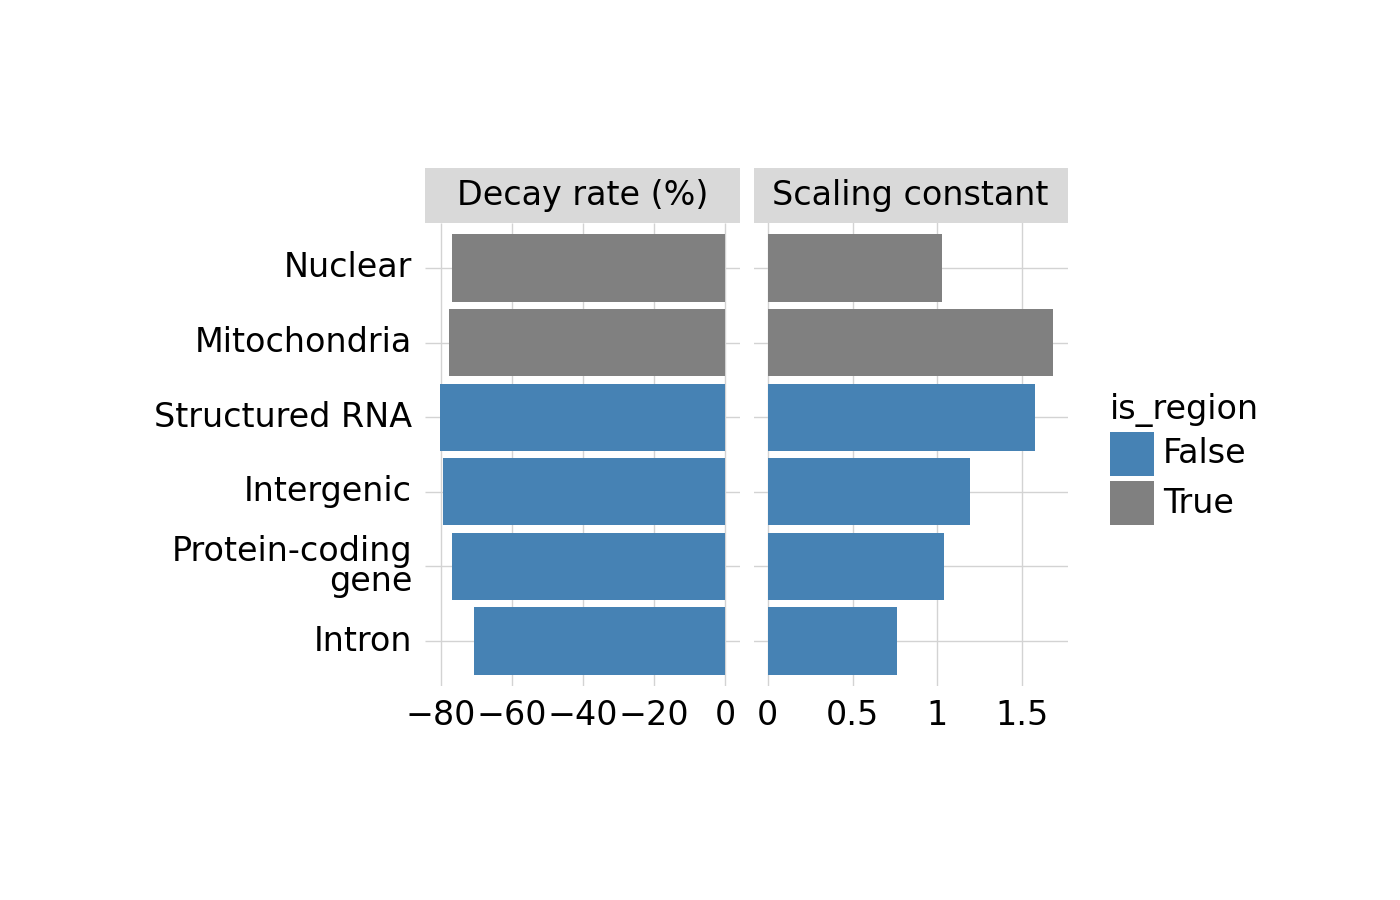

<Figure Size: (700 x 450)>

In [54]:
p_combined = (ggplot(types_decay_melted_df, aes(x='feature', y='value', fill='is_region')) + 
              geom_col() + 
              cowplot_theme(figure_size=(7,4.5)) + 
              theme(plot_margin=.1) + 
              scale_fill_manual(values=['steelblue', 'grey']) +
              labs(x='', y='') +
              coord_flip() +
              facet_grid(' ~ coef_type', scales='free_x', space='free_x') )
p_combined

In [ ]:
ggsave(p_combined, "fig5_decay_scaling_rate_w_mito_nuclear.png",  dpi=500)